In [1]:
import os
import json

In [2]:
def get_number_of_models(file):
    with open(os.path.join(os.path.join("out","d4_compilation_stats"),file), 'r') as fp:
        data = json.load(fp)
    if data['Number of models']=="NaN":
        return -1
    return int(data['Number of models'])

# Data analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [4]:
def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

In [5]:
data = {}
timeout = 1200

In [6]:
def load_maxhd_data(directory, col_name, nb):
    data = {}
    for file in list(os.listdir(directory)):
        with open(os.path.join(directory,file), 'r') as fp:
            data_max = json.load(fp)
            data[file]={}
        for key,tmp in data_max.items():
            if len(tmp)>=nb and is_float(tmp[nb-1]):
                data[file][col_name % key]=tmp[nb-1]
            else: 
                if tmp[-1] == "UNSAT" and tmp[-2]<timeout:
                    data[file][col_name % key]=tmp[-2]
    return data

maxhs_key = "MaxHS Top 20 Enum %s"
tmp = load_maxhd_data("out/top20_config_maxhs", maxhs_key, 20)
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])

In [7]:
def load_compilation_time(directory,col_name):
    data = {}
    for file in list(os.listdir(directory)):
        with open(os.path.join(directory,file), 'r') as fp:
            data_d4 = json.load(fp)
        data[file] = {}
        if data_d4['Compilation time'] != "NaN":
            data[file][col_name]=data_d4['Compilation time']
        else:
            data[file][col_name]=pd.NA
    return data

compil_key = "d4 compilation (seconds)"
tmp =load_compilation_time("out/d4_compilation_stats",compil_key)
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])


In [8]:
def load_jddnnf_data(directory, col_name):
    data = {}
    for file in list(os.listdir(directory)):
        with open(os.path.join(directory,file), 'r') as fp:
            data_j = json.load(fp)
        data[file] = {}
        for key,tmp in data_j.items():
            if tmp['total'] != "TIMEOUT":
                data[file][col_name % key]=tmp['total']
            else:
                data[file][col_name % key]=pd.NA
    return data

jddnnf_key = "jddnnf Top 20 Enum %s"
tmp = load_jddnnf_data("out/top20_config_jddnnf",jddnnf_key)
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])

In [9]:
data_df = pd.DataFrame.from_dict(data,orient='index')


# Computing the average for MaxHS

In [10]:
maxhs_ave_key = "MaxHS Top 20 average (seconds)"
data_df[maxhs_ave_key] = (data_df[maxhs_key % "0"] + data_df[maxhs_key % "1"] + data_df[maxhs_key % "3"] + 
                          data_df[maxhs_key % "2"] + data_df[maxhs_key % "4"])/5

In [11]:
max_df = data_df[[maxhs_key % str(key) for key in range(5)]]

data_df.loc[max_df.isnull().any(axis=1),maxhs_ave_key] = timeout
data_df.loc[data_df[maxhs_ave_key]>timeout,maxhs_ave_key] = timeout

# Taking care of d4 failure

In [12]:
data_df.loc[data_df[[compil_key]].isnull().any(axis=1),compil_key] = timeout
data_df.loc[data_df[compil_key]>timeout,compil_key] = timeout

# Computing the average for jddnnf

In [13]:
jddnnf_ave_key = "Top k average (seconds)"
data_df[jddnnf_ave_key] = (data_df[jddnnf_key % "0"] + data_df[jddnnf_key % "1"] + data_df[jddnnf_key % "2"] + 
                           data_df[jddnnf_key % "3"] + data_df[jddnnf_key % "4"])/5

In [14]:
max_df = data_df[[jddnnf_key % str(key) for key in range(5)]]

data_df.loc[max_df.isnull().any(axis=1),jddnnf_ave_key] = timeout
data_df.loc[data_df[jddnnf_ave_key]>timeout,jddnnf_ave_key] = timeout


In [15]:
total_key = "Total dDNNF (seconds)"
data_df[total_key]=data_df[jddnnf_ave_key]+data_df["d4 compilation (seconds)"]
data_df.loc[data_df[total_key]>timeout,total_key] = timeout

In [16]:
tmp_df = data_df[data_df["d4 compilation (seconds)"]==timeout]
tmp_df = tmp_df[tmp_df[maxhs_ave_key]!=timeout]
print("# of instances solved by MaxHS but not by d4: %d" % tmp_df.shape[0])

tmp_df = data_df[data_df[maxhs_ave_key]==timeout]
tmp_df = tmp_df[tmp_df["d4 compilation (seconds)"]!=timeout]
print("# of instances solved by d4 but not by maxhs: %d" % tmp_df.shape[0])

# of instances solved by MaxHS but not by d4: 156
# of instances solved by d4 but not by maxhs: 80


# MaxHS vs full jddnnf

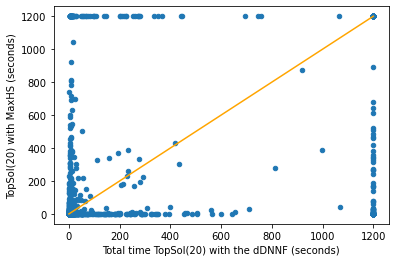

In [17]:
plot_df = data_df[[total_key,maxhs_ave_key]].copy()
plot_df = plot_df.rename(columns={total_key:"Total time TopSol(20) with the dDNNF (seconds)", maxhs_ave_key:"TopSol(20) with MaxHS (seconds)"})
plot_df.plot("Total time TopSol(20) with the dDNNF (seconds)","TopSol(20) with MaxHS (seconds)",kind="scatter")
plt.plot([0,timeout],[0,timeout],'-',color="orange")
plt.show()

In [18]:
tmp_df = data_df[data_df[total_key]==timeout]
tmp_df = tmp_df[tmp_df[maxhs_ave_key]!=timeout]
print("# of instances solved by MaxHS but not by d4: %d" % tmp_df.shape[0])
tmp_df = data_df[data_df[maxhs_ave_key]==timeout]
tmp_df = tmp_df[tmp_df[total_key]!=timeout]
print("# of instances solved by d4 but not by maxhs: %d" % tmp_df.shape[0])
tmp_df = data_df[data_df[maxhs_ave_key]!=timeout]
print("# successes for the MaxHS approach: %d" % tmp_df.shape[0])
print("Success rate for the maxHS approach: %0.2f" % (100*(tmp_df.shape[0])/data_df.shape[0]))
tmp_df = data_df[data_df[total_key]!=timeout]
print("# successes for the compilation approach: %d" % tmp_df.shape[0])
print("Success rate for the dNNF approach: %0.2f" % (100*(tmp_df.shape[0])/data_df.shape[0]))
tmp_df = data_df[data_df[maxhs_ave_key]<data_df[total_key]]
print("Number of example where MaxHS is faster: %d" % tmp_df.shape[0])
tmp_df = data_df[data_df[maxhs_ave_key]>data_df[total_key]]
print("Number of example where dDNNF is faster: %d" % tmp_df.shape[0])

# of instances solved by MaxHS but not by d4: 158
# of instances solved by d4 but not by maxhs: 78
# successes for the MaxHS approach: 1241
Success rate for the maxHS approach: 87.15
# successes for the compilation approach: 1161
Success rate for the dNNF approach: 81.53
Number of example where MaxHS is faster: 544
Number of example where dDNNF is faster: 775
